In [1]:
#@title Importig library

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import operator
from tqdm import tqdm
tqdm.pandas()
import gc
from IPython.display import clear_output
#@title Install kaggle
!pip install kaggle

#@title upload kaggle api from your profile
from google.colab import files
files.upload()

#@title Modification to use kaggle dataset
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /content/kaggle.json

#@title Downloading the dataset
%cd /content
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification
!kaggle datasets download -d yekenot/fasttext-crawl-300d-2m
!kaggle datasets download -d a11rand0m/quoratextemb
clear_output()

In [2]:
!unzip /content/fasttext-crawl-300d-2m.zip
!unzip /content/quoratextemb.zip
clear_output()

In [3]:
max_words=100000
max_seq_size=256

In [5]:
%%time
train_df = pd.read_csv('train.csv.zip')
test_df  = pd.read_csv('test.csv.zip')
sub_df   = pd.read_csv('sample_submission.csv.zip')

CPU times: user 14.9 s, sys: 1.42 s, total: 16.3 s
Wall time: 16.2 s


In [6]:
print("Shape of train data: ",train_df.shape)
print("Shape of test data: ",test_df.shape)

Shape of train data:  (1804874, 45)
Shape of test data:  (97320, 2)


In [7]:
train_df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


# The columns we need are: target and comment_text

In [8]:
train_df = train_df[["target", "comment_text"]]

# Data Cleaning

### Combining different embedding

In [9]:
# Use for combine the vector files that have given 
def combine_embedding(vec_files):
    
    # convert victor to float16 to make it use less memory
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float16')

    # make our embed smaller by get_coefs
    def optimize_embedding(embedding): 
        optimized_embedding = {}
        for word in embedding.vocab:
            optimized_embedding[word] = np.asarray(embedding[word], dtype='float16')
        return optimized_embedding

    
    # load embed vector from file
    def load_embed(file):
        print("Loading {}".format(file))

        if file == '/content/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
            return dict(get_coefs(*o.strip().split(" ")) for o in open(file) if len(o) > 100)
        
        elif file == '/content/crawl-300d-2M.vec':
            return optimize_embedding(KeyedVectors.load_word2vec_format(file))

        else:
            return dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
        
    combined_embedding = {}
    for file in vec_files:
        combined_embedding.update(load_embed(file))
    return combined_embedding

In [10]:
vec_files = [
    "/content/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec",
    "/content/embeddings/glove.840B.300d/glove.840B.300d.txt",
    "/content/crawl-300d-2M.vec"
]

In [11]:
%%time
embedding_index = combine_embedding(vec_files)
covered_vocabs = set(list(embedding_index.keys()))
embedding_index.clear()

Loading /content/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
Loading /content/embeddings/glove.840B.300d/glove.840B.300d.txt
Loading /content/crawl-300d-2M.vec
CPU times: user 12min 4s, sys: 24.2 s, total: 12min 28s
Wall time: 12min 18s


In [12]:
gc.collect()

52

## Clean compound letter

In [13]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
    "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
    "Trump's": "trump is", "Obama's": "obama is", "Canada's": "canada is", "today's": "today is"
}

In [14]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    words = [contraction_mapping[word] if word in contraction_mapping else word for word in text.split(" ")]
    return ' '.join(words)

In [15]:
train_df["comment_text"] = train_df["comment_text"].progress_apply(lambda text: clean_contractions(text))

100%|██████████| 1804874/1804874 [00:21<00:00, 84517.64it/s]


## Clean special characters

In [16]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
specail_signs = { "…": "...", "₂": "2"}

unknown_puncts = []
for p in punct:
    if p not in covered_vocabs:
        unknown_puncts.append(p)
print(' '.join(unknown_puncts))

def clean_special_chars(text):
    for s in specail_signs: 
        text = text.replace(s, specail_signs[s])
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

In [17]:
train_df["comment_text"] = train_df["comment_text"].progress_apply(lambda text: clean_special_chars(text))

100%|██████████| 1804874/1804874 [00:42<00:00, 42502.99it/s]


In [18]:
special_caps_mapping = { 
    "ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", "ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m",
    "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", "s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z",
    "𝘊": "C", "𝘦": "e", "𝘳": "r", "𝘢": "a", "𝘵": "t", "𝘰": "o", "𝘤": "c", "𝘺": "y", "𝘴": "s", "𝘪": "i", "𝘧": "f", "𝘮": "m", "𝘣": "b",
    "м": "m", "υ": "u", "т": "t", "ѕ": "s", "𝙀": "E", "𝒛": "z", "𝑲": "K", "𝑳": "L", "𝑾": "W", "𝒋": "j", "𝟒": "4",
    "𝙒": "W", "𝘾": "C", "𝘽": "B", "𝑱": "J", "𝑹": "R", "𝑫": "D", "𝑵": "N", "𝑪": "C", "𝑯": "H", "𝒒": "q", "𝑮": "G", "𝗕": "B", "𝗴": "g", 
    "𝟐": "2", "𝗸": "k", "𝗟": "L", "𝗠": "M", "𝗷": "j", "𝐎": "O", "𝐍": "N", "𝐊": "K", "𝑭": "F", "Е": "E"
}

def clean_small_caps(text):
    for char in special_caps_mapping:
        text = text.replace(char, special_caps_mapping[char])
    return text

train_df["comment_text"] = train_df["comment_text"].progress_apply(lambda text: clean_small_caps(text))

100%|██████████| 1804874/1804874 [00:22<00:00, 82034.11it/s]


## clean emoji

In [19]:
emojis = "🍕🐵😑😢🐶️😜😎👊😁😍💖💵👎😀😂🔥😄🏻💥😋👏😱🚌ᴵ͞🌟😊😳😧🙀😐😕👍😮😃😘💩💯⛽🚄😖🏼🚲😟😈💪🙏🎯🌹😇💔😡👌🙄😠😉😤⛺🙂😏🍾🎉😞🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪🐰🐇🐱🙆😨🙃💕💗💚🙈😴🏿🤗🇺🇸⤵🏆🎃😩👮💙🐾🐕😆🌠🐟💫💰💎🖐🙅⛲🍰🤐👆🙌💛🙁👀🙊🙉🚬🤓😵😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓😣⏺😌🤑🌏😯😲💞🚓🔔📚🏀👐💤🍇🏡❔⁉👠》🇹🇼🌸🌞🎲😛💋💀🎄💜🤢َِ🗑💃📣👿༼つ༽😰🤣🐝🎅🍺🎵🌎͟🤡🤥😬🤧🚀🤴😝💨🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦🍀😫🤤🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪🇫🇷🇩🇪😷🇨🇦🌐📺🐋💘💓💐🌋🌄🌅👺🐷🚶🤘ͦ💸👂👃🎫🚢🚂🏃👽😙🎾👹⎌🏒⛸🏄🐀🚑🤷🤙🐒🐈ﷻ🦄🚗🐳👇⛷👋🦊🐽🎻🎹⛓🏹🍷🦆♾🎸🤕🤒⛑🎁🏝🦁🙋😶🔫👁💲🗯👑🚿💡😦🏐🇰🇵👾🐄🎈🔨🐎🤞🐸💟🎰🌝🛳🍭👣🏉💭🎥🐴👨🤳🦍🍩😗🏂👳🍗🕉🐲🍒🐑⏰💊🌤🍊🔹🤚🍎𝑷🐂💅💢💒🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻🤖🎎😼🕷👼📉🍟🍦🌈🔭《🐊🐍🐦🐡💳ἱ🙇🥜🔼"

def remove_emojis(text):
    for emoji in emojis:
        text = text.replace(emoji, '')
    return text

train_df["comment_text"] = train_df["comment_text"].progress_apply(lambda text: remove_emojis(text))

100%|██████████| 1804874/1804874 [01:30<00:00, 19839.23it/s]


In [20]:
del covered_vocabs
gc.collect()

103

# Test Data Cleaning

In [21]:
def clean_up_text_with_all_process(text):
    text = text.lower()
    text = clean_contractions(text)
    text = clean_special_chars(text)
    text = clean_small_caps(text)
    return text

test_df["comment_text"] = test_df["comment_text"].progress_apply(lambda text: clean_up_text_with_all_process(text))

100%|██████████| 97320/97320 [00:04<00:00, 21454.96it/s]


## Word cloud

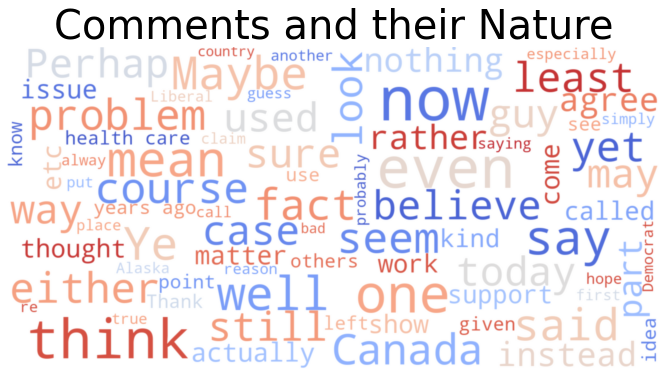

In [22]:
from wordcloud import WordCloud

words = ' '.join([text for text in train_df['comment_text'] ])

word_cloud = WordCloud(width=1600,
                       height=800,
                       colormap='coolwarm', 
                       margin=2,
                       max_words=500,
                       max_font_size=150, 
                       min_font_size=30, 
                       background_color="white").generate(words)

plt.figure(figsize=(12,6))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('Comments and their Nature', fontsize = 40)
plt.axis("off")
plt.show()

# Tokenizing the data

In [23]:
%%time
tranformer = Tokenizer(lower = True, filters='', num_words=max_words)
tranformer.fit_on_texts(list(train_df["comment_text"].values) + list(test_df["comment_text"].values) )

CPU times: user 1min 23s, sys: 274 ms, total: 1min 24s
Wall time: 1min 23s


In [24]:
train_df["comment_text"].values

array(["This is so cool .  It  '  s like ,    '  would you want your mother to read this ?  ?   '   Really great idea ,  well done ! ",
       'Thank you !  !  This would make my life a lot less anxiety  -  inducing .  Keep it up ,  and do not let anyone get in your way ! ',
       'This is such an urgent design problem ;  kudos to you for taking it on .  Very impressive ! ',
       ...,
       'thank you  ,  ,  , right or wrong ,  ,  ,  i am following your advice',
       'Anyone who is quoted as having the following exchange ,  even if apocryphal ,  would have received my vote !  \n\nBessie Braddock :    "  Winston ,  you are drunk ,  and what is more you are disgustingly drunk .   "  \nWinston Churchill :    "  Bessie ,  my dear ,  you are ugly ,  and what is more ,  you are disgustingly ugly .  But tomorrow I shall be sober and you will still be disgustingly ugly .   "  ',
       'Students defined as EBD are legally just as disabled and eligible for special services as a developmen

## Transforming the train and test data

In [25]:
%%time
transformed_x = tranformer.texts_to_sequences(train_df["comment_text"].values)
transformed_x = pad_sequences(transformed_x, maxlen = max_seq_size)

x_predict = tranformer.texts_to_sequences(test_df["comment_text"])
x_predict = pad_sequences(x_predict, maxlen = max_seq_size)

CPU times: user 1min 22s, sys: 1.34 s, total: 1min 23s
Wall time: 1min 22s


In [26]:
print(transformed_x.shape)
print(transformed_x)

(1804874, 256)
[[   0    0    0 ...  109  236   36]
 [   0    0    0 ...   47  108   36]
 [   0    0    0 ...  116 5104   36]
 ...
 [   0    0    0 ... 1117   47 1821]
 [   0    0    0 ... 2625    1   12]
 [   0    0    0 ...  647   51  893]]


In [27]:
print(x_predict.shape)
print(x_predict)

(97320, 256)
[[  0   0   0 ...  63 129  20]
 [  0   0   0 ...  68 117  36]
 [  0   0   0 ...   1   1   1]
 ...
 [  0   0   0 ...   9 905   1]
 [  0   0   0 ...  93 174   1]
 [  0   0   0 ...  16 275   1]]


# Embedding matrix of of the whole dataset

In [28]:
word_index = tranformer.word_index # index of the word in the embedding space
total_vocab = len(word_index) + 1
embedding_size = 300

In [29]:
%%time
def build_embedding_matrix(word_index, total_vocab, embedding_size):
    embedding_index = combine_embedding(vec_files)
    matrix = np.zeros((total_vocab, embedding_size))
    for word, index in tqdm(word_index.items()):
        try:
            matrix[index] = embedding_index[word]
        except KeyError:
            pass
    return matrix

embedding_matrix = build_embedding_matrix(tranformer.word_index, total_vocab, embedding_size)

Loading /content/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
Loading /content/embeddings/glove.840B.300d/glove.840B.300d.txt
Loading /content/crawl-300d-2M.vec


100%|██████████| 443385/443385 [00:00<00:00, 526994.08it/s]

CPU times: user 11min 52s, sys: 20.9 s, total: 12min 13s
Wall time: 12min 5s


In [30]:
del tranformer
del word_index
del embedding_index
gc.collect()

50

# Preprocessing for model Input

In [31]:
y = (train_df['target'].values > 0.5).astype(int)

x_train, x_test, y_train, y_test = train_test_split(transformed_x, y, random_state=10, test_size=0.15)

In [32]:
# %%time
# from numpy import asarray
# from numpy import savez_compressed
# data = embedding_matrix
# data2 = transformed_x
# data3 = y
# data4 = x_test
# data5 = y_test
# data6 = x_predict

# savez_compressed('embedding_matrix.npz', data)
# savez_compressed('transformed_x.npz', data2)
# savez_compressed('y.npz', data3)
# savez_compressed('x_test.npz', data4)
# savez_compressed('y_test.npz', data5)
# savez_compressed('x_predict.npz', data6)

In [33]:
# !cp embedding_matrix.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles
# !cp transformed_x.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles
# !cp y.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles
# !cp x_test.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles
# !cp y_test.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles
# !cp x_predict.npz /content/drive/MyDrive/nlpFiles/PreprocessedFiles

# Model

In [34]:
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D

sequence_input = Input(shape=(max_seq_size,), dtype='int32')
embedding_layer = Embedding(total_vocab,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_seq_size,
                            trainable=False)

x_layer = embedding_layer(sequence_input)
x_layer = SpatialDropout1D(0.2)(x_layer)
x_layer = Bidirectional(LSTM(64, return_sequences=True))(x_layer)   
x_layer = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_layer)
avg_pool1 = GlobalAveragePooling1D()(x_layer)
max_pool1 = GlobalMaxPooling1D()(x_layer)     
x_layer = concatenate([avg_pool1, max_pool1])
preds = Dense(1, activation=sigmoid)(x_layer)
model = Model(sequence_input, preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 300)     133015800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 256, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 128)     186880      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

# Callback and Training

In [50]:
epochs=20
batch_size=248

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True)
earlystop =  EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks)

Epoch 1/20
6187/6187 [==============================] - 317s 51ms/step - loss: 0.0711 - accuracy: 0.9724 - val_loss: 0.0900 - val_accuracy: 0.9653

Epoch 00001: val_loss improved from inf to 0.08995, saving model to model.h5
Epoch 2/20
6187/6187 [==============================] - 312s 50ms/step - loss: 0.0702 - accuracy: 0.9727 - val_loss: 0.0907 - val_accuracy: 0.9658

Epoch 00002: val_loss did not improve from 0.08995
Epoch 3/20
6187/6187 [==============================] - 312s 50ms/step - loss: 0.0694 - accuracy: 0.9730 - val_loss: 0.0939 - val_accuracy: 0.9633

Epoch 00003: val_loss did not improve from 0.08995
Epoch 4/20
6187/6187 [==============================] - 312s 50ms/step - loss: 0.0685 - accuracy: 0.9734 - val_loss: 0.0913 - val_accuracy: 0.9657

Epoch 00004: val_loss did not improve from 0.08995

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
6187/6187 [==============================] - 311s 50ms/step - loss: 0.0640 - accuracy

In [60]:
history.history

{'accuracy': [0.9724093079566956,
  0.9726824760437012,
  0.973015546798706,
  0.9733590483665466,
  0.9752675890922546,
  0.9755935072898865,
  0.9757362604141235,
  0.9760041832923889,
  0.9760328531265259,
  0.9759253263473511,
  0.9760615229606628],
 'loss': [0.07105245441198349,
  0.0702357217669487,
  0.06936823576688766,
  0.06850481778383255,
  0.06400851160287857,
  0.06329219788312912,
  0.06274684518575668,
  0.06204687058925629,
  0.06197800487279892,
  0.06203297898173332,
  0.061965081840753555],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.000100000005,
  0.000100000005,
  0.000100000005,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1e-05],
 'val_accuracy': [0.9652682542800903,
  0.9657816290855408,
  0.9632699489593506,
  0.9656671285629272,
  0.9646144509315491,
  0.9641896486282349,
  0.964333713054657,
  0.9640751481056213,
  0.9640530347824097,
  0.9642007350921631,
  0.9638055562973022],
 'val_loss': [0.08995047211647034,
  0.0906590074300766,
  0.09394361

# Visualizing loss

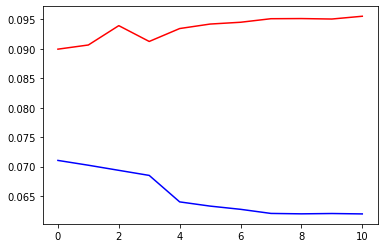

In [61]:
plt.plot(history.history['loss'], color='b', label="Training accuracy")
plt.plot(history.history['val_loss'], color='r', label="Validation  accuracy")
plt.show()

# Visualizing Accuracy

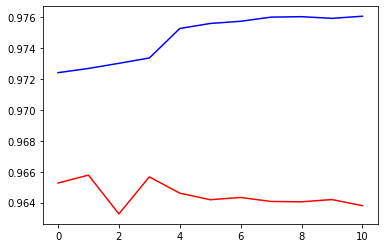

In [62]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r', label="Validation  accuracy")
plt.show()

# Evaluation

In [63]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)

1092/1092 [==============================] - 30s 27ms/step - loss: 0.0955 - accuracy: 0.9638


In [ ]:
print('Validation accuracy:', score[1])
print('Validation loss:', score[0])

In [ ]:
y_predict = model.predict(x_predict)
sub_df["prediction"] = y_predict
sub_df

In [ ]:
sub_df.to_csv("submission.csv", index=False)

In [65]:
sub_df.to_csv("/content/drive/MyDrive/nlpFiles/submission20epoch.csv", index=False)

score: 0.92284